In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import os
import numpy as np

In [2]:
from telemetry.models.periodogram import frequencies
from telemetry.algorithms.transfer.model import TransferFunction
from telemetry.algorithms.transfer.linfit import apply_fitter
from astropy.modeling.fitting import LevMarLSQFitter
import astropy.units as u

In [3]:
def bode_plot(transfer_data, freq, sym=True, **kwargs):
    """Helper function for making bode plots."""
    plt.plot(freq, transfer_data, **kwargs)
    if sym:
        plt.plot(-freq, transfer_data, **kwargs)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(0.1, freq.max().value)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel(r"$\left|\textrm{Power}\right|^{2}$")

## Load Data
We will be working with a stacked periodogram of slopes, using the default control matrix, with a gain setting of 0.2

In [4]:
case = "s2100"
file = h5py.File(os.path.expanduser("~/Documents/Telemetry/ShaneAO/2016-04-18/telemetry/telemetry_{}.hdf5".format(case)))
tf = file['/transferfunction/hcoefficients/data']

In [5]:
transfer_functions = tf[...]
rate = 1000 * u.Hz
freq = frequencies(transfer_functions.shape[0], rate)

Here are all of the transfer functions we have to work with. There are 224 transfer functions (one for each WFS mode)

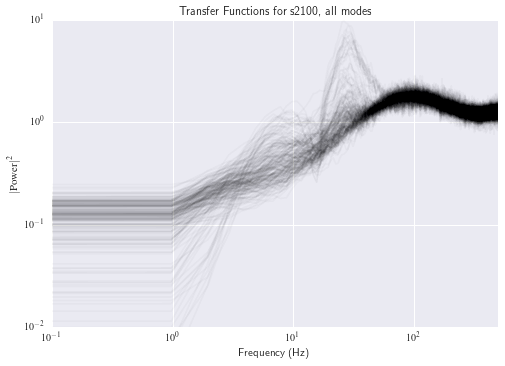

In [6]:
bode_plot(transfer_functions, freq, alpha=0.01, c='k')
plt.ylim(1e-2, 10)
plt.title("Transfer Functions for {}, all modes".format(case))

## Low-order transfer function
By selecting only the first 20 modes, we can look at system performance in the low-order case. The modes are roughly ordered by spatial frequency.

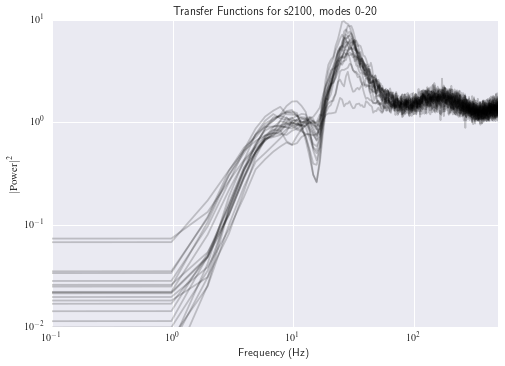

In [7]:
bode_plot(transfer_functions[:,:20], freq, alpha=0.1, c='k')
plt.ylim(1e-2, 10)
plt.title("Transfer Functions for {}, modes 0-20".format(case))

Immediately, we notice that these modes are doing something funky. Lets average these and make a single low-order transfer function.

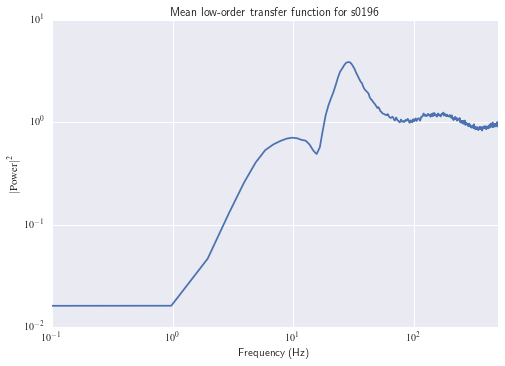

In [8]:
stf_lo = transfer_functions[:,:20].mean(axis=1)
stf_lo *= (1.0/stf_lo[np.abs(freq) > 100 * u.Hz].mean())
bode_plot(stf_lo, freq, sym=False)
plt.ylim(1e-2, 10)
plt.title("Mean low-order transfer function for s0196")

In [9]:
f = LevMarLSQFitter()
model_init = TransferFunction(tau=(1.0 / 1000.0) + 900e-6, gain=0.05, integrator=0.995, rate=1000)

In [10]:
model_init_fit = TransferFunction(tau=0.01, gain=0.06, integrator=0.998, rate=1000)
model = f(model_init_fit, freq, np.log(stf_lo), maxiter=2000)
print(model)

Model: TransferFunction
Inputs: ('freq',)
Outputs: ('y',)
Model set size: 1
Parameters:
          tau              gain        integrator   rate 
    ---------------- --------------- ------------- ------
    0.00624967974499 0.0620249493542 0.99254781921 1000.0


We will have to avoid fitting the high frequency regime to avoid the kink in the transfer function, which I can't model right now since I don't know what causes it.

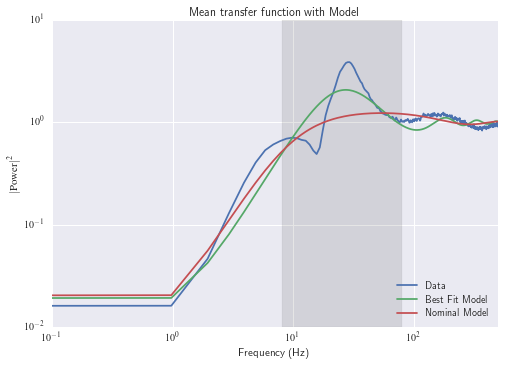

In [11]:
bode_plot(stf_lo, freq, sym=False, label="Data")
bode_plot(np.exp(model(freq.value)), freq, sym=False, label="Best Fit Model")
bode_plot(np.exp(model_init(freq.value)), freq, sym=False, label="Nominal Model")
plt.ylim(1e-2, 10)
plt.axvspan(8, 80, color='k', alpha=0.1)
plt.title("Mean transfer function with Model")
plt.legend(loc='lower right')

In [12]:
def gauss_freq_weighting(freq):
    sig = np.max(freq)/4.0
    w = np.exp(-0.5 * (freq/sig)**2.0)
    return w

In [13]:
model_init_fit = TransferFunction(tau=1.0 / 1000.0, gain=0.02, integrator=0.998, rate=1000)
select = (np.abs(freq.value) < 8.0) | (np.abs(freq.value) > 80.0)
model = f(model_init_fit, freq[select], np.log(stf_lo[select]), weights=gauss_freq_weighting(freq[select]))
print(model)

Model: TransferFunction
Inputs: ('freq',)
Outputs: ('y',)
Model set size: 1
Parameters:
           tau              gain        integrator    rate 
    ----------------- --------------- -------------- ------
    0.000851399308583 0.0432396625343 0.995857859809 1000.0


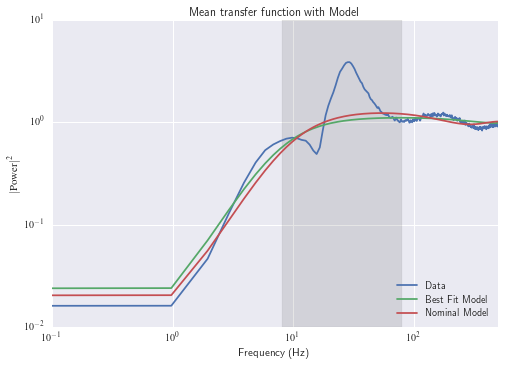

In [14]:
bode_plot(stf_lo, freq, sym=False, label="Data")
bode_plot(np.exp(model(freq.value)), freq, sym=False, label="Best Fit Model")
bode_plot(np.exp(model_init(freq.value)), freq, sym=False, label="Nominal Model")
plt.ylim(1e-2, 10)
plt.axvspan(8, 80, color='k', alpha=0.1)
plt.title("Mean transfer function with Model")
plt.legend(loc='lower right')

## Mid-order transfer function
We can conduct the same excercisze for modes 40 to 100

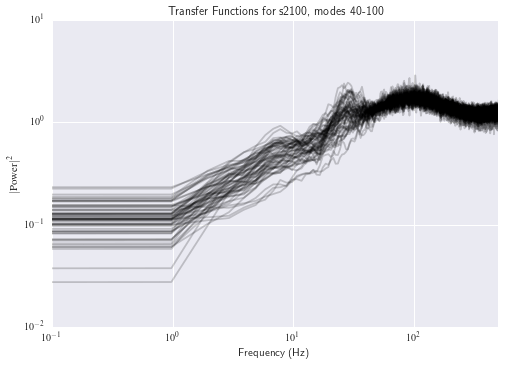

In [15]:
bode_plot(transfer_functions[:,40:100], freq, alpha=0.1, c='k')
plt.ylim(1e-2, 10)
plt.title("Transfer Functions for {}, modes 40-100".format(case))

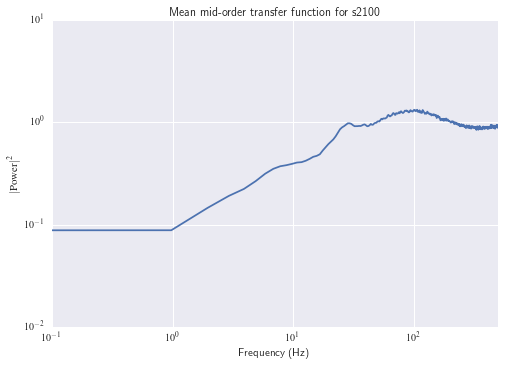

In [16]:
stf_mid = transfer_functions[:,40:100].mean(axis=1)
stf_mid *= (1.0/stf_mid[np.abs(freq) > 50 * u.Hz].mean())
bode_plot(stf_mid, freq, sym=False)
plt.ylim(1e-2, 10)
plt.title("Mean mid-order transfer function for {}".format(case))

In [17]:
model_init_fit = TransferFunction(tau=0.001, gain=0.07, integrator=0.97, rate=1000)
model = f(model_init_fit, freq, np.log(stf_mid),  weights=gauss_freq_weighting(freq), maxiter=1000)
print(model)

Model: TransferFunction
Inputs: ('freq',)
Outputs: ('y',)
Model set size: 1
Parameters:
          tau              gain        integrator    rate 
    ---------------- --------------- -------------- ------
    0.00100435462744 0.0698852377924 0.958123519757 1000.0


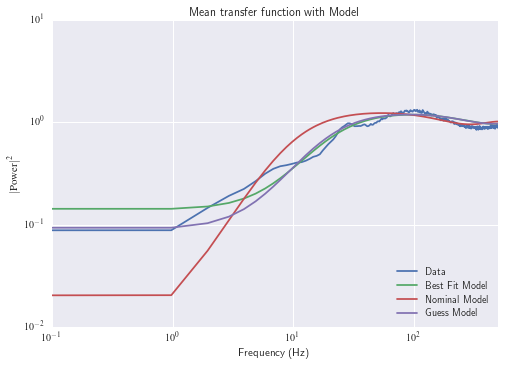

In [18]:
bode_plot(stf_mid, freq, sym=False, label="Data")
bode_plot(np.exp(model(freq.value)), freq, sym=False, label="Best Fit Model")
bode_plot(np.exp(model_init(freq.value)), freq, sym=False, label="Nominal Model")
bode_plot(np.exp(model_init_fit(freq.value)), freq, sym=False, label="Guess Model")

plt.ylim(1e-2, 10)
plt.title("Mean transfer function with Model")
plt.legend(loc='lower right')

## High order modes

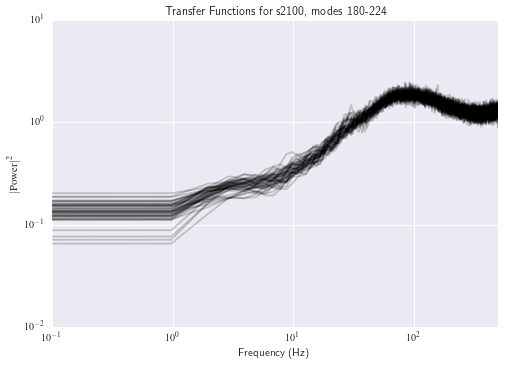

In [19]:
bode_plot(transfer_functions[:,180:], freq, alpha=0.1, c='k')
plt.ylim(1e-2, 10)
plt.title("Transfer Functions for {}, modes 180-224".format(case))

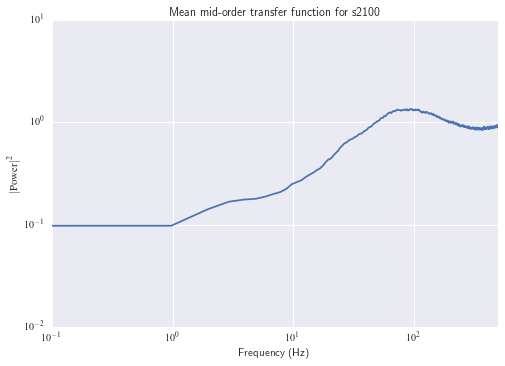

In [20]:
stf_high = transfer_functions[:,180:].mean(axis=1)
stf_high *= (1.0/stf_high[np.abs(freq) > 50 * u.Hz].mean())
bode_plot(stf_high, freq, sym=False)
plt.ylim(1e-2, 10)
plt.title("Mean mid-order transfer function for {}".format(case))

In [21]:
model_init_fit = TransferFunction(tau=0.002, gain=0.09, integrator=0.995, rate=1000)
model = f(model_init_fit, freq, np.log(stf_high),  weights=gauss_freq_weighting(freq), maxiter=3000)
print(model)

Model: TransferFunction
Inputs: ('freq',)
Outputs: ('y',)
Model set size: 1
Parameters:
          tau             gain        integrator    rate 
    ---------------- -------------- -------------- ------
    0.00100837889398 0.114911337888 0.931834440438 1000.0


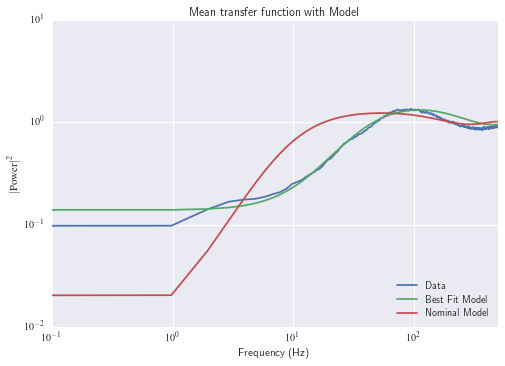

In [22]:
bode_plot(stf_high, freq, sym=False, label="Data")
bode_plot(np.exp(model(freq.value)), freq, sym=False, label="Best Fit Model")
bode_plot(np.exp(model_init(freq.value)), freq, sym=False, label="Nominal Model")
plt.ylim(1e-2, 10)
plt.title("Mean transfer function with Model")
plt.legend(loc='lower right')